<a href="https://colab.research.google.com/github/vincent4u/Plant_disease-classification-Msc_thesis-/blob/main/Untitled66.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 54.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: ten

# *Importing system libraries*

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# ***Creating important functions***


***Functions to Create DataFrame from Dataset***


In [2]:
# Function to generate file paths and corresponding labels from a given directory
def define_paths(data_dir):
    """
    This function iterates through directories and subdirectories within the provided data directory,
    collecting file paths and assigning them labels based on the parent directory they reside in.

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing two lists: filepaths (a list of absolute paths to all files) and labels (a list of labels corresponding to each file).
    """
    filepaths = []  # List to store absolute paths of all files
    labels = []     # List to store labels for each file

    # Get a list of all folders/directories in the data directory
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)  # Construct the full path to the current folder
        filelist = os.listdir(foldpath)           # Get a list of all files in the current folder

        for file in filelist:
            fpath = os.path.join(foldpath, file)  # Construct the full path to the current file
            filepaths.append(fpath)               # Append the file path to the list
            labels.append(fold)                   # Append the label (folder name) to the list

    return filepaths, labels


# Function to concatenate file paths and labels into a single DataFrame
def define_df(files, classes):
    """
    This function creates two pandas Series objects from the provided lists of file paths and labels,
    then concatenates these series side by side into a single DataFrame. This DataFrame will serve as the input
    for further processing, such as splitting into training, validation, and testing sets.

    Parameters:
    - files: A list of file paths.
    - classes: A list of labels corresponding to each file.

    Returns:
    - A DataFrame with two columns: 'filepaths' and 'labels', where 'filepaths' contains the paths to the files
      and 'labels' contains the corresponding labels.
    """
    Fseries = pd.Series(files, name='filepaths')  # Create a Series object for file paths
    Lseries = pd.Series(classes, name='labels')   # Create a Series object for labels

    return pd.concat([Fseries, Lseries], axis=1)  # Concatenate the two Series along the column axis


# Function to split the combined DataFrame into training, validation, and testing sets
def split_data(data_dir):
    """
    This function performs the following steps:
    1. Generates file paths and labels using the `define_paths` function.
    2. Combines these into a DataFrame using the `define_df` function.
    3. Splits the resulting DataFrame into training, validation, and testing sets, ensuring that the distribution
       of labels across these sets remains consistent (stratified sampling).

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing three DataFrames: train_df (for training), valid_df (for validation), and test_df (for testing).
    """
    # Step 1: Generate file paths and labels
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    # Extracting the labels for stratification
    strat = df['labels']

    # Step 2: Split the DataFrame into training and dummy sets (80% training)
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Step 3: Further split the dummy set into validation and testing sets (50% validation)
    strat = dummy_df['labels']  # Re-extracting the labels for stratification
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


***Function to generate images from dataframe***

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function prepares image data generators for training, validation, and testing datasets.
    It uses Keras' ImageDataGenerator to preprocess images and convert them into tensors
    suitable for model training. The preprocessing includes resizing images to a standard size,
    applying data augmentation techniques like horizontal flipping, and converting images
    into categorical labels based on their file paths and labels columns.

    Parameters:
    - train_df: DataFrame containing training dataset with file paths and corresponding labels.
    - valid_df: DataFrame containing validation dataset with file paths and corresponding labels.
    - test_df: DataFrame containing testing dataset with file paths and corresponding labels.
    - batch_size: Number of samples per gradient update during training time.

    Returns:
    - train_gen: An instance of ImageDataGenerator for the training set.
    - valid_gen: An instance of ImageDataGenerator for the validation set.
    - test_gen: An instance of ImageDataGenerator for the testing set, using a custom batch size calculated to ensure that the total number of batches does not exceed 80.
    '''

    # Define the dimensions of the input images and the number of color channels.
    img_size = (224, 224)                                                       # Standard input size for the model.
    channels = 3                                                                # Using RGB images.
    color = 'rgb'                                                               # Color mode for the images.
    img_shape = (img_size[0], img_size[1], channels)                            # Shape of the input images.

    # Calculate the optimal batch size for the test set to ensure efficient memory usage.
    ts_length = len(test_df)  # Total number of samples in the test set.
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))  # Find the largest divisor of ts_length that divides evenly and keeps the number of batches below 80.
    test_steps = ts_length // test_batch_size                                   # Calculate the number of steps required to iterate over the entire test set.

    # Define a simple preprocessing function that returns the input image unchanged.
    def scalar(img):                                                                  # Placeholder function for demonstration purposes.
        return img

    # Create instances of ImageDataGenerator for both training and testing sets.
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)  # Apply horizontal flip for data augmentation.
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)                        # No data augmentation for the test set.

    # Generate data generators for the training, validation, and test sets.
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',                                                             # Column name for file paths in the DataFrame.
        y_col='labels',                                                                # Column name for labels in the DataFrame.
        target_size=img_size,                                                          # Resize images to the specified size.
        class_mode='categorical',                                                      # Use categorical labels.
        color_mode=color,                                                              # Specify the color mode.
        shuffle=True,                                                                  # Shuffle the data.
        batch_size=batch_size                                                          # Batch size for training.
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # For the test set, use the custom batch size calculation and disable shuffling.
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,                                  # Do not shuffle the test set.
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


# ***Viewing the Data sample***


In [4]:
def show_images(gen):
    '''
    This function displays a sample of images generated by the given data generator.
    It retrieves a batch of images along with their labels from the generator,
    selects a subset of these images for display, and then plots them using matplotlib.
    Each image is labeled with its predicted class name.

    Parameters:
    - gen: A data generator object, typically returned by methods like flow_from_directory() or
    flow_from_dataframe() in Keras' ImageDataGenerator.

    Notes:
    - The function assumes that the data generator yields batches of images and their corresponding labels.
    - The number of images displayed is limited to a maximum of 25 to avoid cluttering the plot.
    - Images are normalized to the range [0, 255] for better visualization.
    '''

    # Retrieve the mapping between class indices and class names from the generator.
    g_dict = gen.class_indices                                                        # Dictionary mapping class names to indices. defines dictionary {'class': index}
    classes = list(g_dict.keys())                                                     # List of class names extracted from the dictionary keys.

    # Fetch a batch of images and their labels from the generator.
    images, labels = next(gen)                                                        # Get a batch of images and their labels.

    # Determine the number of images to display, up to a maximum of 25.
    length = len(labels)                                                              # Length of the batch.
    sample = min(length, 25)                                                          # Limit the number of displayed images to 25 or fewer.

    # Initialize a figure for plotting the images.
    plt.figure(figsize=(20, 20))                                                      # Set the figure size.

    # Loop through the selected images and plot each one.
    for i in range(sample):
        plt.subplot(5, 5, i + 1)                                                      # Position the subplot.

        # Normalize the image pixel values to the range [0, 255].
        image = images[i] / 255

        # Display the image.
        plt.imshow(image)

        # Retrieve the label index of the current image.
        index = np.argmax(labels[i])

        # Extract the class name corresponding to the label index.
        class_name = classes[index]

        # Add a title to the subplot indicating the class name.
        plt.title(class_name, color='blue', fontsize=12)

        # Hide axes for cleaner visualization.
        plt.axis('off')

    # Display the figure with the plotted images.
    plt.show()


# ***Implementing a callback***
 creating a call back class

In [5]:
class MyCallback(keras.callbacks.Callback):
    """
    Custom callback class for dynamic learning rate adjustment and
    early stopping based on training and validation metrics.

    This callback dynamically adjusts the learning rate based on the performance of the model
    on the training and validation datasets. It also implements early stopping based on a specified number
    of epochs without improvement in validation loss.

    Parameters:
    - model: The Keras model to which this callback is attached.
    - patience: Number of epochs with no improvement after which learning rate is reduced.
    - stop_patience: Number of times the learning rate can be reduced before stopping training.
    - threshold: Training accuracy threshold for adjusting the learning rate based on validation loss.
    - factor: Factor by which to reduce the learning rate.
    - batches: Number of training batches to run per epoch.
    - epochs: Total number of epochs to train for.
    - ask_epoch: Optional parameter to prompt the user to decide whether to continue training past
    a certain epoch.
    """

    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch=None):
        self.model = model                    # Reference to the Keras model instance
        self.patience = patience              # Number of epochs with no improvement after which learning rate is reduced
        self.stop_patience = stop_patience    # Number of times the learning rate can be reduced before stopping training
        self.threshold = threshold            # Training accuracy threshold for adjusting the learning rate based on validation loss
        self.factor = factor                  # Factor by which to reduce the learning rate
        self.batches = batches                # Number of training batches to run per epoch
        self.epochs = epochs                  # Total number of epochs to train for
        self.ask_epoch = ask_epoch            # Epoch at which the user is prompted to decide whether to continue training
        self.ask_epoch_initial = ask_epoch    # Saved initial value of ask_epoch for potential restoration
        self.count = 0                        # Counter for tracking the number of times the learning rate has been reduced without improvement
        self.stop_count = 0                   # Counter for tracking the number of times the learning rate has been reduced consecutively without improvement, triggering early stopping
        self.best_epoch = 1                   # Best epoch identified during training, based on the lowest validation loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))  # Initial learning rate of the model's optimizer
        self.highest_tracc = 0.0              # Highest training accuracy observed during training
        self.lowest_vloss = np.inf            # Lowest validation loss observed during training
        self.best_weights = self.model.get_weights()  # Weights of the model at the best epoch, saved for potential restoration
        self.initial_weights = self.model.get_weights()  # Initial weights of the model, saved for potential restoration

    def on_train_begin(self, logs=None):
        """
        Called at the beginning of training.
        Prompts the user to confirm whether they want to proceed with training.
        """
        msg = 'Do you want model to ask you if you want to halt the training [y/n]?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()   #Records the starting time of the training process using the time.time() function.


    def on_train_end(self, logs=None):
        """
        Called at the end of training.
        Prints the total training duration and restores the model to its best weights.
        """
        stop_time = time.time()                                       #Records the stopping time of the training process using the time.time() function.
        tr_duration = stop_time - self.start_time                     # Calculating the training duration time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        self.model.set_weights(self.best_weights)                     # Restores and sets the model's weights to the best performing weight configuration found during training.


    def on_train_batch_end(self, batch, logs=None):
        """
        Called at the end of each batch.
        Prints the progress of the batch processing.
        """
        acc = logs.get('accuracy') * 100                            # Extracting and converting the model's accuracy to percentage
        loss = logs.get('loss')                                     # Obtaining the current epoch's loss value

        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')



    def on_epoch_begin(self, epoch, logs=None):
        """
        Called at the beginning of each epoch.
        Records the start time of the epoch.
        """
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch.
        Adjusts the learning rate based on the performance of the model on the training and validation datasets.
        Implements early stopping based on a specified number of epochs without improvement in validation loss.
        """
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))        # Retrieves the current learning rate of the model's optimizer
        current_lr = lr                                                        # Stores the current learning rate for comparison
        acc = logs.get('accuracy')                                             # Fetches the training accuracy from the logs
        v_acc = logs.get('val_accuracy')                                       # Retrieves the validation accuracy from the logs
        loss = logs.get('loss')                                                # Gets the training loss from the logs
        v_loss = logs.get('val_loss')                                          # Obtains the validation loss from the logs

        if acc < self.threshold:
            # Switching the monitoring metric to accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                # Calculating improvement in accuracy
                pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc

            # Updating best accuracy and weights if new high is set
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0

                # Updating lowest validation loss if applicable
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1

            else:
                # Reducing learning rate if patience is met
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.count = 0
                    self.stop_count = self.stop_count + 1
                    # Updating lowest validation loss if applicable
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    # Incrementing counter for epochs without improvement
                    self.count = self.count + 1

        else:
            # Switching the monitoring metric to validation loss
            monitor = 'val_loss'
            # Resetting improvement calculation for the first epoch
            if epoch == 0:
                pimprov = 0.0
            else:
                # Calculating improvement in validation loss
                pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss

            # Updating lowest validation loss and weights if new low is set
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1

            else:
                # Reducing learning rate if patience is met
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

                else:
                    # Incrementing counter for epochs without improvemen
                    self.count = self.count + 1

                # Updating highest training accuracy if applicable
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        # Stopping the training if maximum learning rate adjustments without improvement are reached
        if self.stop_count > self.stop_patience - 1:
            msg = f'training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True

        else:
            # Handling user request to halt training or adjust the number of epochs to run
            if self.ask_epoch!= None and self.ask_permission!= 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True       # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f'training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')


# ***Function for Plotting the Training History***

In [6]:
def plot_training(hist):
    '''
    This function takes a training model's history object and plots the training and validation accuracy and loss over epochs,
    highlighting the epoch with the best validation loss and accuracy.
    '''

    # Extracting training and validation metrics from the history object
    tr_acc = hist.history['accuracy']                                       # Training accuracy
    tr_loss = hist.history['loss']                                          # Training loss
    val_acc = hist.history['val_accuracy']                                  # Validation accuracy
    val_loss = hist.history['val_loss']                                     # Validation loss

    # Identifying the epoch with the lowest validation loss and highest validation accuracy
    index_loss = np.argmin(val_loss)                                        # Index of the epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]                                       # Value of the lowest validation loss
    index_acc = np.argmax(val_acc)                                          # Index of the epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]                                        # Value of the highest validation accuracy

    # Creating a list of epochs for plotting
    Epochs = [i+1 for i in range(len(tr_acc))]                              # Adjusting epoch numbers to start from 1

    # Labels for the best epoch in terms of loss and accuracy
    loss_label = f'best epoch= {str(index_loss + 1)}'                        # Label for the best epoch in terms of validation loss
    acc_label = f'best epoch= {str(index_acc + 1)}'                          # Label for the best epoch in terms of validation accuracy

    # Plotting training and validation loss
    plt.figure(figsize=(20, 8))                                             # Setting figure size
    plt.style.use('fivethirtyeight')                                        # Using a style for the plot

    plt.subplot(1, 2, 1)                                                    # Subplot for loss
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')                   # Plotting training loss
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')                 # Plotting validation loss
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Highlighting the best epoch in terms of validation loss
    plt.title('Training and Validation Loss')                                   # Title for the subplot
    plt.xlabel('Epochs')                                                    # X-axis label
    plt.ylabel('Loss')                                                      # Y-axis label
    plt.legend()                                                            # Displaying legend

    plt.subplot(1, 2, 2)                                                    # Subplot for accuracy
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')                # Plotting training accuracy
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')             # Plotting validation accuracy
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Highlighting the best epoch in terms of validation accuracy
    plt.title('Training and Validation Accuracy')                               # Title for the subplot
    plt.xlabel('Epochs')                                                        # X-axis label
    plt.ylabel('Accuracy')                                                      # Y-axis label
    plt.legend()                                                                # Displaying legend

    plt.tight_layout()                                                          # Adjusting layout to prevent overlapping labels
    plt.show()                                                                  # Displaying the plot


# ***Importing and Reading the Dataset from Kaggle***

In [7]:
# I have already done step 1 with the seceret thing
#Step 2: Access and Export your Kaggle secrets to the environment
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

#Step 3: Download Dataset :
#!kaggle datasets download -d emmarex/plantdisease
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

# ! mkdir data_sets
# ! unzip plantdisease.zip -d data_sets

! mkdir data_vin
! unzip plantvillage-dataset.zip -d data_vin


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘data_vin’: File exists
Archive:  plantvillage-dataset.zip
replace data_vin/plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# ***Splitting Dataset into training, Validation and testing***

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


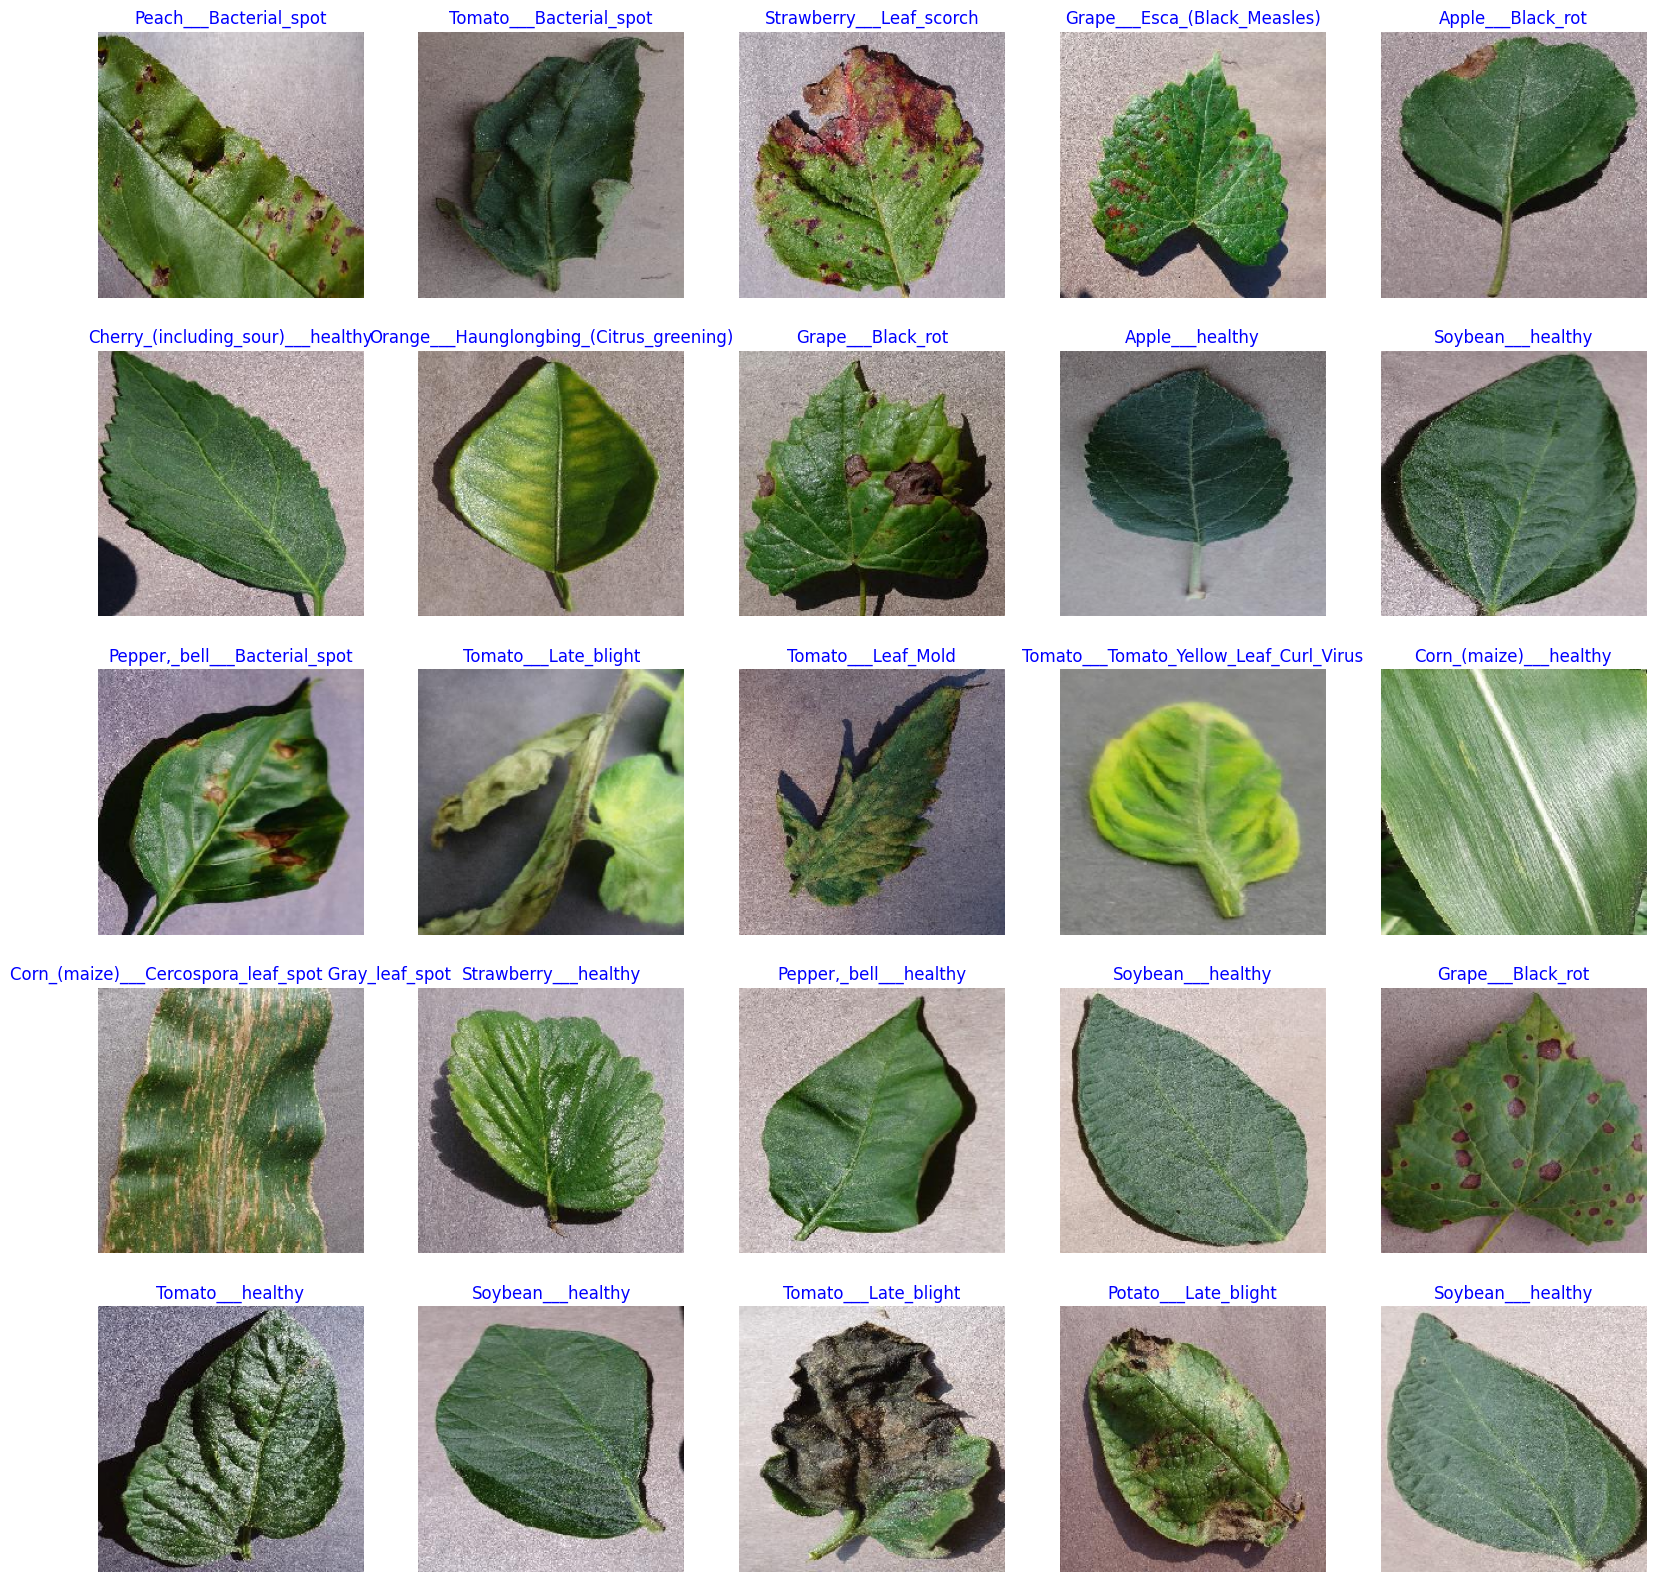

In [8]:

#data_dir = '/content/data_sets/plantvillage/PlantVillage'                 #The Plant Village directory in Kaggle

data_dir = '/content/data_vin/plantvillage dataset/color'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

    # visualizing some images from the training set
    show_images(train_gen)

except Exception as e:
    print('Invalid Input:', str(e))

# ***Creating a Generic Model***

In [9]:
# Defining the dimensions of the input images and the number of color channels.
img_size = (224, 224)                                                 # Standard input size for the model. Common sizes include 224x224, 299x299, etc., depending on the pre-trained model used.
channels = 3                                                          # Using RGB images. Other options could be grayscale (1 channel) or RGBA (4 channels including alpha transparency).

# Combine the height, width, and number of channels to form the shape of the input images.
img_shape = (img_size[0], img_size[1], channels)                      # This shape is used to configure the input layer of the neural network.

# Determine the number of classes in the dataset by counting the unique labels present in the training generator.
class_count = len(list(train_gen.class_indices.keys()))                # This count is used to specify the number of neurons in the final dense layer of the model, matching the number of classes.

# Load a pre-trained EfficientNetB3 model without the top classification layer. This model has been trained on the ImageNet dataset.
# We specify 'include_top=False' to remove the final classification layer, allowing us to add our own.
# 'weights="imagenet"' loads the model pre-trained on ImageNet, which can help improve performance on similar tasks.
# 'input_shape=img_shape' ensures the model expects inputs of the correct shape.
# 'pooling="max"' applies max pooling to the feature maps before passing them to the fully connected layers, reducing dimensionality.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Build the sequential model by stacking layers on top of the base model.
# The base model is added first, followed by additional layers for fine-tuning and classification.
model = Sequential([
    base_model,
    # Add a Batch Normalization layer to normalize the activations of the previous layer at each batch, i.e., apply a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    # Add a Dense layer with 256 units. Regularization is applied to prevent overfitting.
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),
    # Introduce dropout to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training time.
    Dropout(rate=0.45, seed=123),
    # Final Dense layer with a softmax activation function for multi-class classification. The number of neurons matches the number of classes.
    Dense(class_count, activation='softmax')
])

# Compile the model with the Adamax optimizer, specifying the learning rate, loss function, and evaluation metric.
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture, showing the layers and their configurations.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                9766      
                                                                 
Total params: 11,192,917
Trainable params: 11,102,542
Non-trainable params: 90,375
_______________________________________

# ***Activating the Callback***

In [10]:
# Set batch size for training.
batch_size = 40

# Define the total number of epochs for training.
epochs = 40

# Patience parameter for early stopping; specifies the number of epochs to wait before adjusting the learning rate if no improvement is observed.
patience = 1

# Stop patience parameter for early stopping; specifies the number of epochs to wait before stopping training if no improvement is observed.
stop_patience = 3

# Threshold for adjusting the monitored metric during training; if the training accuracy falls below this threshold, switch to monitoring validation loss instead.
threshold = 0.9

# Factor by which to reduce the learning rate when adjusting it during training.
factor = 0.5

# Epoch at which to prompt the user to decide whether to continue training or halt.
ask_epoch = 5

# Calculate the total number of training batches per epoch.
batches = int(np.ceil(len(train_gen.labels) / batch_size))

# Configure callbacks for model training, including early stopping and learning rate adjustment.
callbacks = [
    MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
               factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)
]


# ***Training the model***

In [11]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model to ask you if you want to halt the training [y/n]?
Y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


KeyboardInterrupt: 